# Build a conditional VAE on CIFAR-10 that can generate images of 10 classes

[Benchmark](https://paperswithcode.com/sota/image-generation-on-cifar-10)

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_directml
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Type
from PIL import Image

## Setup device

In [127]:
for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(1)
print("dml =", dml)

device = dml

0 : Radeon RX 5500M
1 : AMD Radeon(TM) Graphics
dml = privateuseone:1


## Load data

In [128]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Variables

In [129]:
version = 5
save_model = False

# Variables
classes = training_data.classes
class_size = len(classes)
channel_num = 3
image_size = 32
train_loss_history = []

# Hyperparameter
batch_size = 64
epochs = 50
kld_weight = 0.00025
latent_dim = 50
learning_rate = 0.005
weight_decay = 0
embedding_dim = 5
evaluation = True

In [130]:
from torch.utils.data import DataLoader

training_data.data = training_data.data.astype("uint8")
test_data.data = test_data.data.astype("uint8")

kwargs = {"num_workers": 1, "pin_memory": True}

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False, **kwargs)

## Show some samples

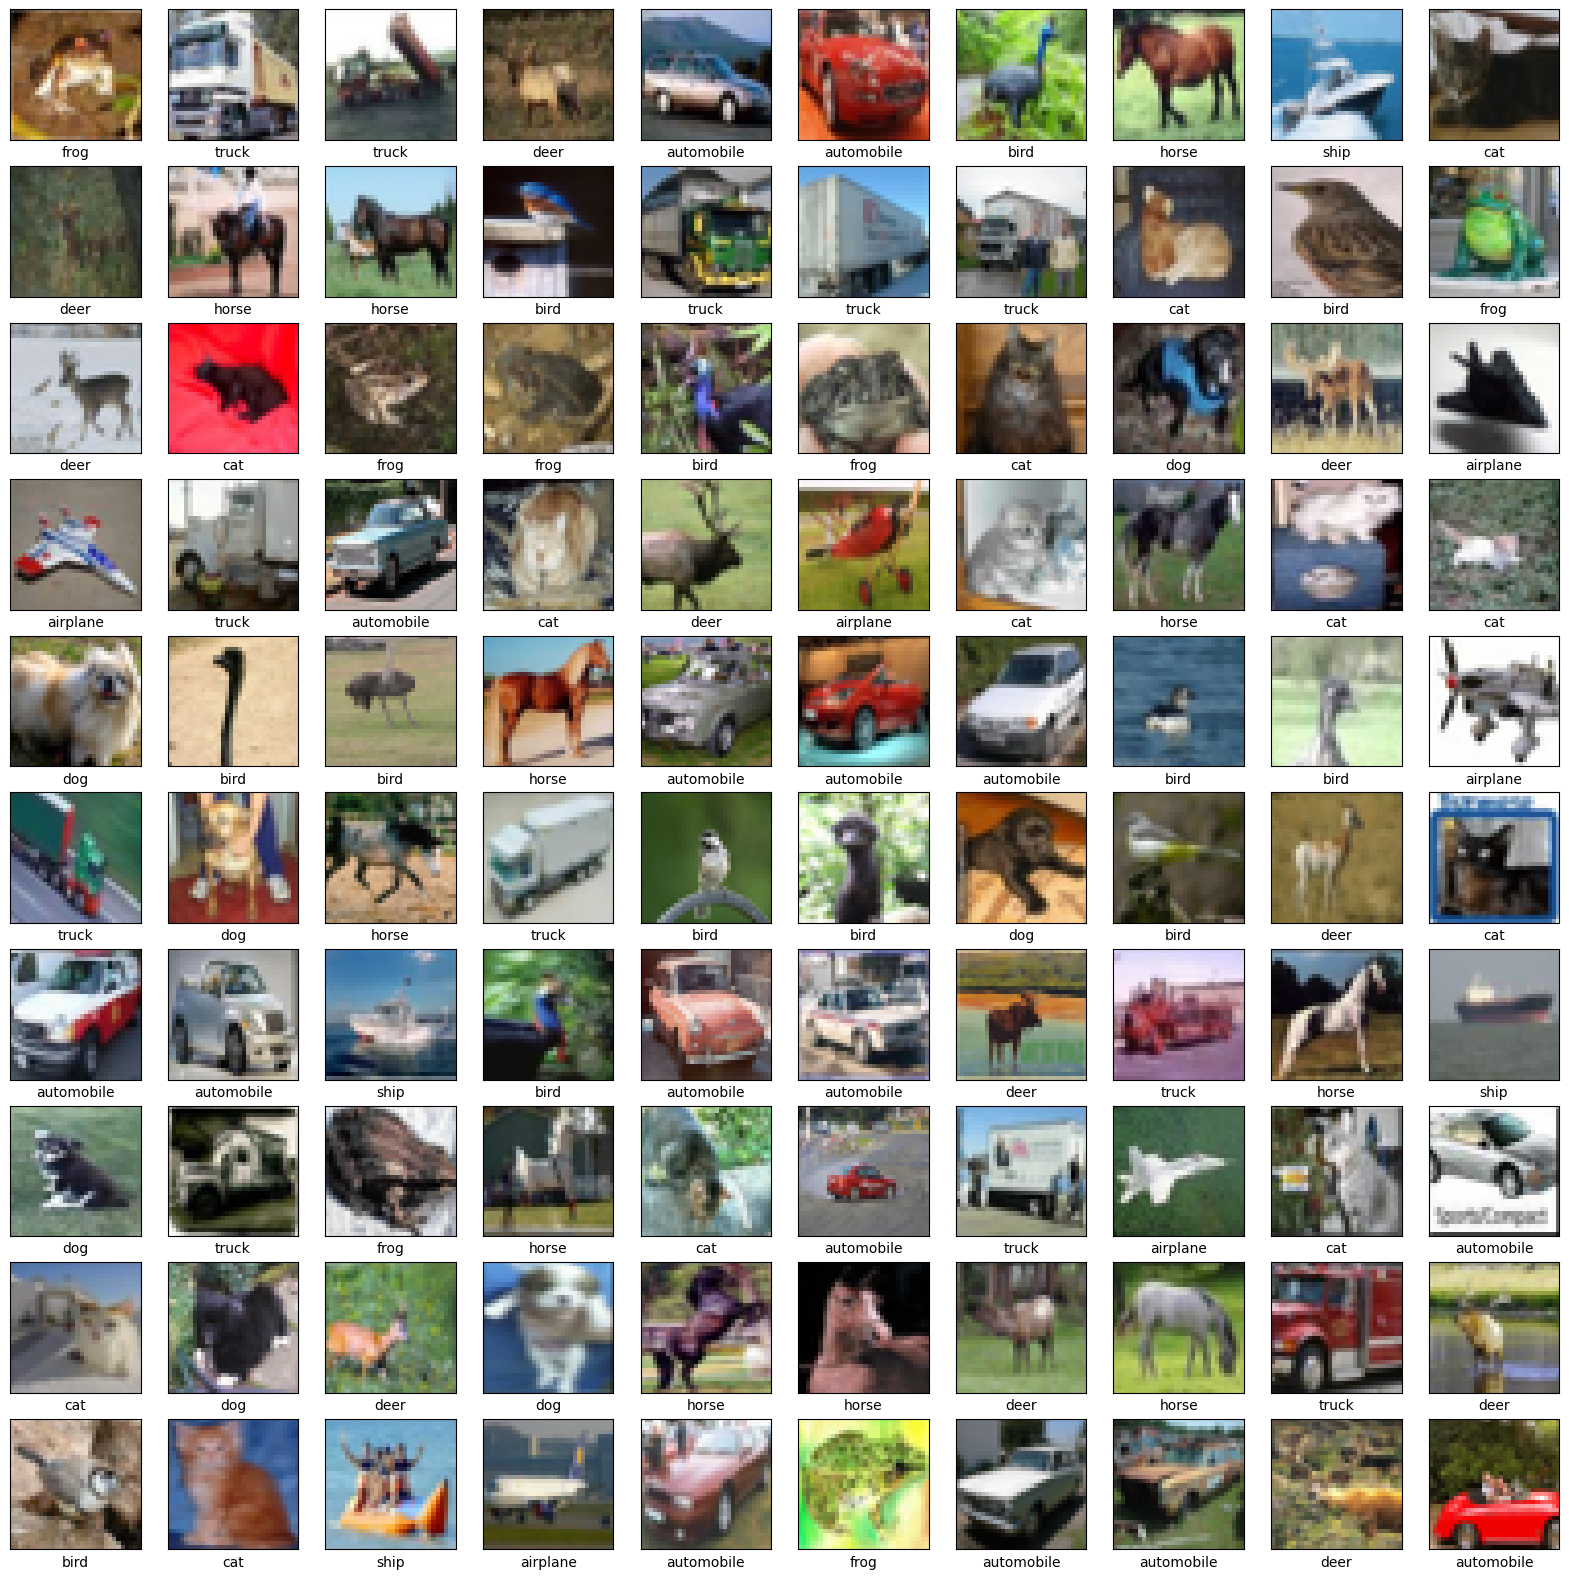

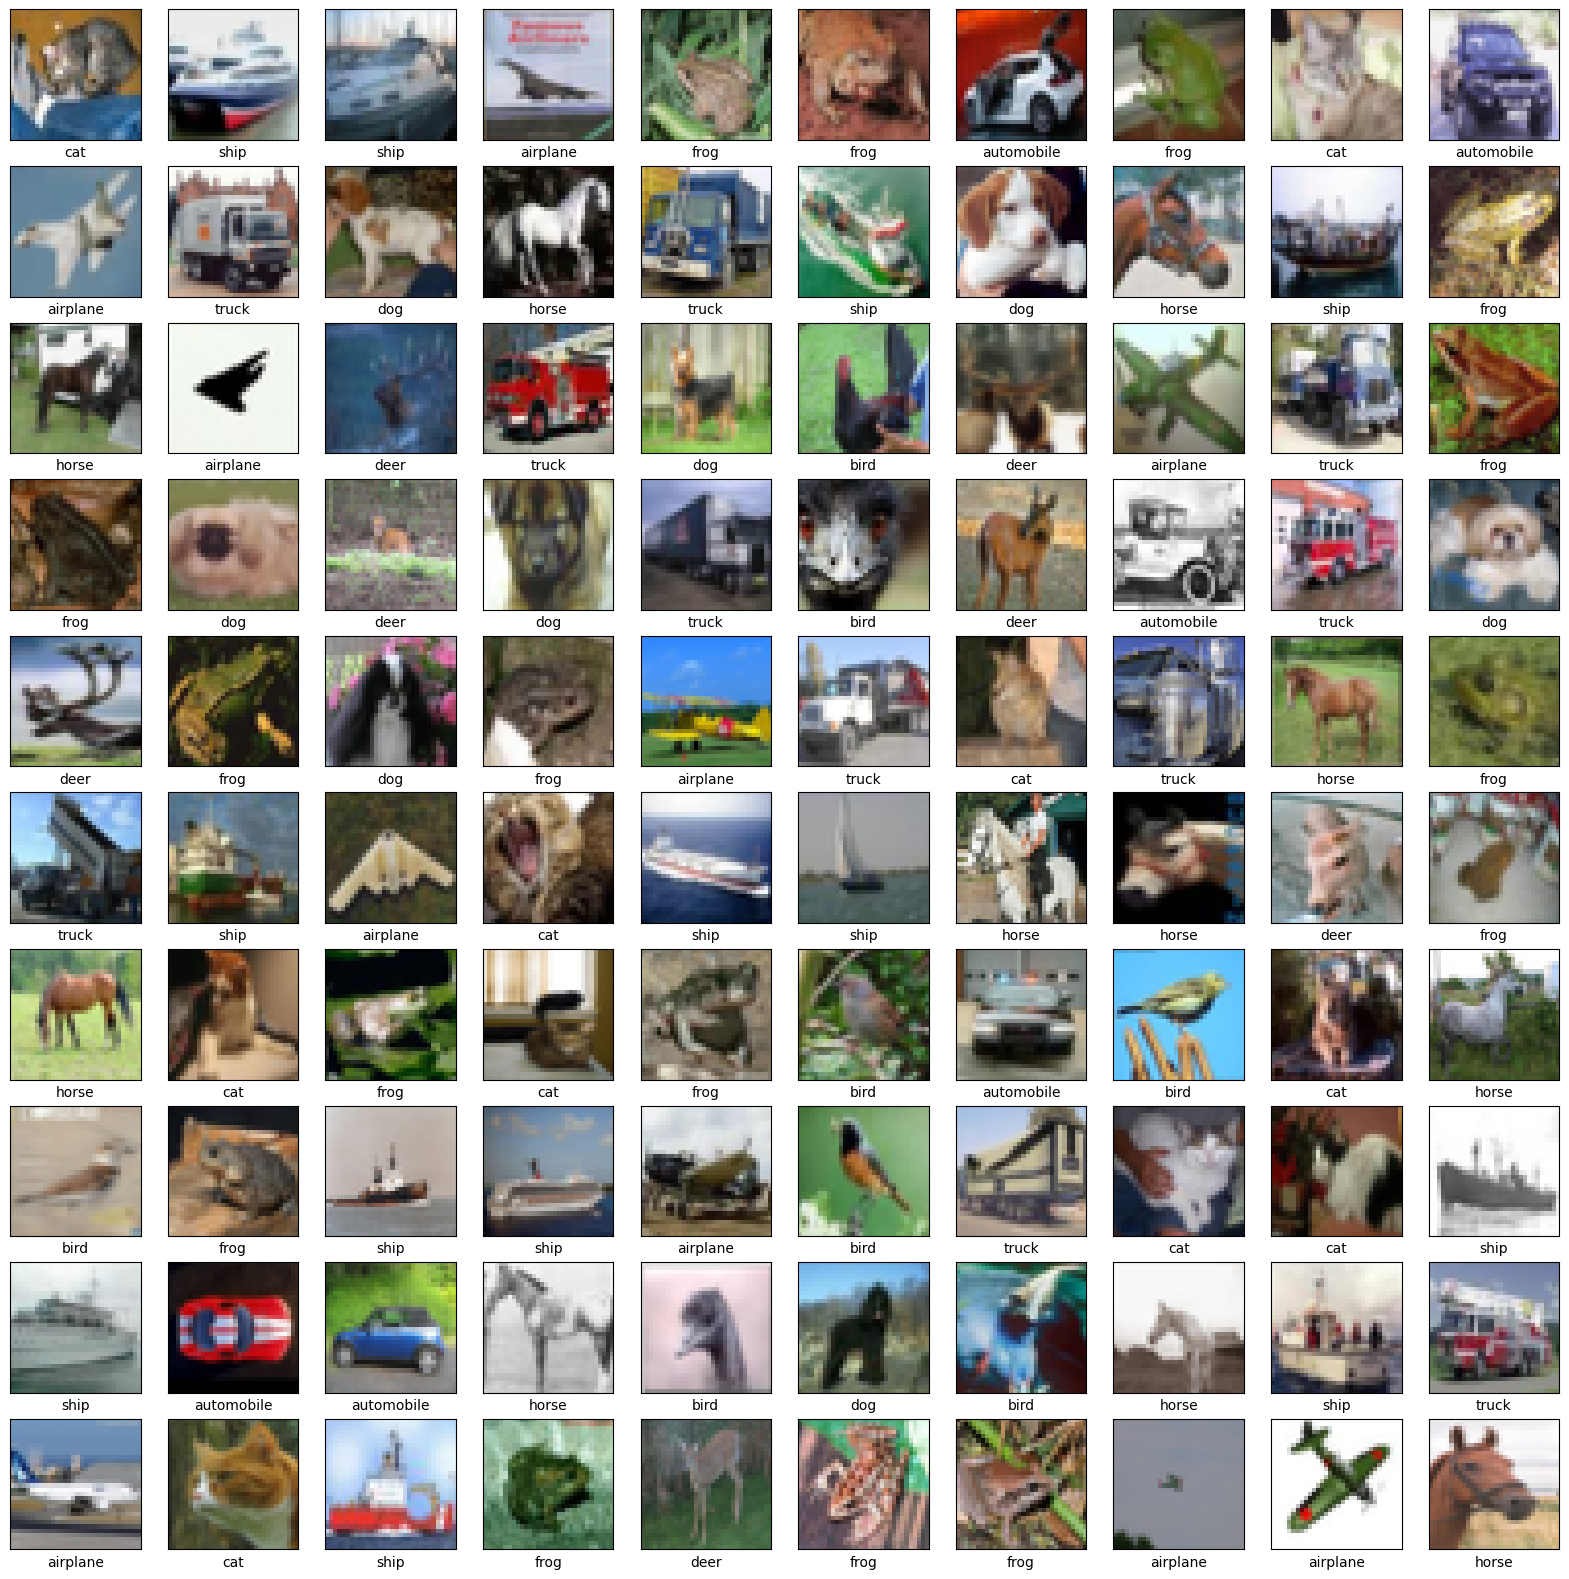

In [131]:
def show_cifar10_images(images, labels):
    plt.figure(figsize=[20, 20])

    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

    plt.show()


show_cifar10_images(training_data.data, training_data.targets)
show_cifar10_images(test_data.data, test_data.targets)

In [132]:
np.array(training_data.targets)

array([6, 9, 9, ..., 9, 1, 1])

In [133]:
np.array(training_data.classes)

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

## Data shape

In [134]:
print("Training images shape: ", training_data.data.shape)
print("Test images shape: ", test_data.data.shape)

Training images shape:  (50000, 32, 32, 3)
Test images shape:  (10000, 32, 32, 3)


## Build CVAE model

[cVAE mechanism](https://idiotdeveloper.com/introduction-to-autoencoders/)

![cVAE mechanism](./images/variational-autoencoder.png)

Ref.

[Understanding Conditional Variational Autoencoders](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[Conditional Variational Autoencoder (cVAE) using PyTorch](https://github.com/unnir/cVAE)

[Conditional Variational Autoencoder in Keras](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

[GAN Evaluation : the Frechet Inception Distance and Inception Score metrics](https://colab.research.google.com/github/pytorch-ignite/pytorch-ignite.ai/blob/gh-pages/blog/2021-08-11-GAN-evaluation-using-FID-and-IS.ipynb#scrollTo=Stp59yfH65VO)
                                                                              
[Conditional Variational Autoencoders with Learnable Conditional Embeddings](https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a)
                                                                              
Main architecture
                                                                              
[CVAE model](https://github.com/jaywonchung/Learning-ML/blob/master/Implementations/Conditional-Variational-Autoencoder/model.py)
                                                                              
[Loss function](https://github.com/AntixK/PyTorch-VAE/blob/master/models/cvae.py)

### Loss function

In [135]:
def loss_function(out_mu, x, z_mu, z_sigma):
    """Reconstruction + KL divergence losses summed over all elements and batch

    See Appendix B from VAE paper:

    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114

    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """

    # reconstruction_term = F.mse_loss(out_mu, x.view(-1, 3 * 32 * 32))
    # KL_divergence_term = torch.mean(-0.5 * torch.sum(1 + z_sigma - z_mu**2 - z_sigma.exp(), dim=1), dim=0)
    # loss = reconstruction_term + KL_divergence_term * kld_weight

    # return loss

    reconstruction_term = -0.5 * torch.sum((x.view(-1, 32 * 32 * 3) - out_mu) ** 2)
    KL_divergence_term = 0.5 * torch.sum(z_mu**2 + z_sigma**2 - torch.log(1e-8 + z_sigma**2) - 1.0, dim=1)
    loss = reconstruction_term - KL_divergence_term * kld_weight

    return -torch.mean(loss)

### Encoder

In [137]:
class GaussianEncoder(nn.Module):
    """Gaussian encoder module for VAE"""

    def __init__(self, embedding_dim, latent_dim, conv_dims=[64, 128, 256], kernel_size=4):
        """
        Constructor for the GaussianEncoder class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
        """
        super().__init__()

        assert len(conv_dims) == 3

        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.conv_dims = conv_dims

        # x: (N, 3, 32, 32 + embedding_dim)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_dims[0], kernel_size=kernel_size, stride=2, padding=1)
        # x: (N, 64, 16, (32 + embedding_dim) / 2)
        self.conv2 = nn.Conv2d(
            in_channels=conv_dims[0], out_channels=conv_dims[1], kernel_size=kernel_size, stride=2, padding=1
        )
        self.bn2 = nn.BatchNorm2d(num_features=conv_dims[1])
        # x: (N, 128, 8, (32 + embedding_dim) / 4)
        self.conv3 = nn.Conv2d(
            in_channels=conv_dims[1], out_channels=conv_dims[2], kernel_size=kernel_size, stride=2, padding=1
        )
        self.bn3 = nn.BatchNorm2d(num_features=conv_dims[2])
        # x: (N, 256, 4, (32 + embedding_dim) / 8)
        self.fc4 = nn.Linear(
            in_features=conv_dims[2] * 4 * int((32 + self.embedding_dim) / 8), out_features=2 * self.latent_dim
        )
        # x: (N, 2 * latent_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        """
        Forward method for the GaussianEncoder class

        Parameter:
            x: Batch of (images + onehot labels) => (N, 3, 32, 42).

        Return:
            mu: Vector of size latent_dim.
                Each element represents the mean of a Gaussian Distribution.
            sigma: Vector of size latent_dim.
                   Each element represents the standard deviation of a Gaussian distribution.
        """

        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.view(-1, self.conv_dims[2] * 4 * int((32 + self.embedding_dim) / 8))
        x = self.fc4(x)

        # split x in half
        mu = x[:, : self.latent_dim]
        # sigma shouldn't be negative
        sigma = 1e-6 + F.softplus(x[:, self.latent_dim :])

        return mu, sigma

### Decoder

In [138]:
class GaussianDecoder(nn.Module):
    """GaussianDecoder module for VAE"""

    def __init__(
        self,
        embedding_dim,
        latent_dim,
        model_sigma=False,
        deconv_dims=[256, 128, 64],
        kernel_size=4,
        first_latent_out_dims=[448, 2, 2],
    ):
        """
        Constructor for the GaussianDecoder class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
            model_sigma: Whether to model standard deviations too.
                         If False, only outputs the mu vector, and all sigma is implicitly 1.
        """
        super().__init__()

        assert len(deconv_dims) == 3
        assert len(first_latent_out_dims) == 3

        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.model_sigma = model_sigma
        self.first_latent_out_dims = first_latent_out_dims

        latent_out_dims = torch.prod(torch.Tensor(first_latent_out_dims)).int()

        # z: (N, latent_dim + 10)
        self.fc1 = nn.Linear(
            in_features=self.latent_dim + self.embedding_dim,
            out_features=latent_out_dims,
        )
        self.bn1 = nn.BatchNorm1d(num_features=latent_out_dims)
        # z: (N, 448 * 2 * 2)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=first_latent_out_dims[0],
            out_channels=deconv_dims[0],
            kernel_size=kernel_size,
            stride=2,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=deconv_dims[0])
        # z: (N, 256, 4, 4)
        self.deconv3 = nn.ConvTranspose2d(
            in_channels=deconv_dims[0], out_channels=deconv_dims[1], kernel_size=kernel_size, stride=2, padding=1
        )
        # z: (N, 128, 8, 8)
        self.deconv4 = nn.ConvTranspose2d(
            in_channels=deconv_dims[1], out_channels=deconv_dims[2], kernel_size=kernel_size, stride=2, padding=1
        )
        # z: (N, 64, 16, 16)
        if model_sigma:
            self.deconv5 = nn.ConvTranspose2d(
                in_channels=deconv_dims[2], out_channels=6, kernel_size=kernel_size, stride=2, padding=1
            )
            # z: (N, 6, 32, 32)
        else:
            self.deconv5 = nn.ConvTranspose2d(
                in_channels=deconv_dims[2], out_channels=3, kernel_size=kernel_size, stride=2, padding=1
            )
            # z: (N, 3, 32, 32)

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, z):
        """
        Forward method for the GaussianDecoder class

        Parameter:
            z: Batch of latent variables.

        Return:
            embedding_dim: Dimension of embeded class
            mu: Vector of size latent_dim.
                Each element represents the mean of a Gaussian Distribution.
            sigma: Vector of size latent_dim.
                   Each element represents the standard deviation of a Gaussian distribution.
        """

        z = F.relu(self.bn1(self.fc1(z)))
        z = z.view(-1, self.first_latent_out_dims[0], self.first_latent_out_dims[1], self.first_latent_out_dims[2])
        z = F.relu(self.bn2(self.deconv2(z)))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        if self.model_sigma:
            gaussian = self.deconv5(z)
            mu = torch.sigmoid(gaussian[:, :3, :, :]).unsqueeze(1)
            sigma = 1e-6 + F.softplus(gaussian[:, 3:, :, :]).unsqueeze(1)
            return mu, sigma
        else:
            mu = torch.sigmoid(self.deconv5(z))
            return mu

### CVAE

In [139]:
from torchinfo import summary


class CVAE(nn.Module):
    """Conditional Variational Autoencoder module that wraps one encoder and one decoder module."""

    def __init__(
        self,
        embedding_dim=5,
        latent_dim=50,
        model_sigma=False,
        device="cpu",
        conv_dims=[64, 128, 256],
        deconv_dims=[256, 128, 64],
        conv_kernel_size=4,
        deconv_kernel_size=4,
    ):
        """
        Constructor for VAE class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
            model_sigma: Whether to model standard deviations too.
                         If True, forward method returns (mu, sigma). Else, returns only mu.
            device: the device to use for conv_y
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.model_sigma = model_sigma
        self.device = device

        self.encoder = GaussianEncoder(self.embedding_dim, self.latent_dim, conv_dims, conv_kernel_size)
        self.decoder = GaussianDecoder(
            self.embedding_dim, self.latent_dim, self.model_sigma, deconv_dims, deconv_kernel_size
        )
        self.embed_cond = nn.Embedding(num_embeddings=class_size, embedding_dim=embedding_dim, max_norm=True)

    def forward(self, x, y):
        """
        Forward method for the GaussianEncoder class
        Samples latent variable z from the distribution calculated by the encoder,
        and feeds it to the decoder

        Parameter:
            x: Batch of images => (N, 3, 32, 32).
            y: Label of batch.

        Return:
            If model_sigma is True, returns (z_mu, z_sigma, mu, sigma)
            Else, returns (z_mu, z_sigma, mu)
        """
        y = torch.Tensor(y).int()
        y = self.embed_cond(y)
        y = y.view(-1, self.embedding_dim)

        # Encode
        conv_y = y.view(-1, 1, 1, self.embedding_dim) * torch.ones(
            (x.shape[0], x.shape[1], x.shape[2], self.embedding_dim)
        ).to(self.device)
        input_batch = torch.cat((x, conv_y), dim=3)
        z_mu, z_sigma = self.encoder(input_batch)
        self.z = z_mu + z_sigma * torch.randn_like(z_mu)  # reparametrization trick

        # Decode
        latent = torch.cat((self.z, y), dim=1)
        mu = self.decoder(latent)
        return (z_mu, z_sigma) + (mu,)

    def generate_images(self, repeat_size):
        """從隨機分布中生成指定數量的圖片"""

        with torch.no_grad():
            labels = torch.Tensor(np.tile(np.arange(class_size), repeat_size)).to(device).int()
            y = self.embed_cond(labels)
            y = y.view(-1, self.embedding_dim)

            noises_z = torch.randn(repeat_size * class_size, latent_dim).to(device)
            latent = torch.cat((noises_z, y), dim=1)
            samples = self.decoder(latent)

            return samples.cpu(), labels

In [140]:
model = CVAE(
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    model_sigma=False,
    device=device,
    conv_dims=[32, 64, 128],
    deconv_dims=[128, 64, 32],
    conv_kernel_size=4,
    deconv_kernel_size=4,
).to(device)

summary_model = CVAE(
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    model_sigma=False,
    device="cpu",
    conv_dims=[32, 64, 128],
    deconv_dims=[128, 64, 32],
    conv_kernel_size=4,
    deconv_kernel_size=4,
).to("cpu")

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

summary(
    summary_model,
    input_size=[(batch_size, channel_num, image_size, image_size), [batch_size]],
    device="cpu",
)

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [64, 50]                  --
├─Embedding: 1-1                         [64, 5]                   50
├─GaussianEncoder: 1-2                   [64, 50]                  --
│    └─Conv2d: 2-1                       [64, 32, 16, 18]          1,568
│    └─Conv2d: 2-2                       [64, 64, 8, 9]            32,832
│    └─BatchNorm2d: 2-3                  [64, 64, 8, 9]            128
│    └─Conv2d: 2-4                       [64, 128, 4, 4]           131,200
│    └─BatchNorm2d: 2-5                  [64, 128, 4, 4]           256
│    └─Linear: 2-6                       [64, 100]                 204,900
├─GaussianDecoder: 1-3                   [64, 3, 32, 32]           --
│    └─Linear: 2-7                       [64, 1792]                100,352
│    └─BatchNorm1d: 2-8                  [64, 1792]                3,584
│    └─ConvTranspose2d: 2-9              [64, 128, 4, 4]  

### Training

In [141]:
def train_step(epoch, data_loader: Type[DataLoader]):
    model.train()
    train_loss = 0
    loss = torch.Tensor()
    current_data_len = 0

    for batch_idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        current_data_len = len(data)

        optimizer.zero_grad()

        z_mu, z_sigma, out_mu = model(data, labels)
        out_mu = out_mu.view(-1, channel_num * image_size * image_size)
        loss = loss_function(out_mu, data, z_mu, z_sigma)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()

        optimizer.step()

        # log
        if batch_idx % 20 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    (batch_idx + 1) * len(data),
                    len(data_loader.dataset),
                    100.0 * (batch_idx + 1) / len(data_loader),
                    loss.item() / len(data),
                ),
                end="\r",
            )

            n = min(data.size(0), 5)
            comparison = torch.cat([data[:n], out_mu.view(-1, channel_num, image_size, image_size)[:n]])
            save_image(
                comparison.cpu(),
                "./outputs/cifar-10-cvae-outputs/temp/gen/reconstruction_" + str(f"{epoch:02}") + ".png",
                nrow=n,
            )

    # Last batch of this epoch
    print(
        "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch,
            len(data_loader.dataset),
            len(data_loader.dataset),
            100,
            loss.item() / current_data_len,
        ),
        end="\r\n",
    )

    # Calculate average loss of this epoch
    train_loss /= len(data_loader.dataset)
    train_loss_history.append(train_loss)

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss))


for epoch in range(1, epochs + 1):
    train_step(epoch, train_loader)
    samples, labels = model.generate_images(1)
    save_image(
        samples,
        "./outputs/cifar-10-cvae-outputs/temp/gen/sample_" + str(f"{epoch:02}") + ".png",
    )

Train Epoch: 1 [50000/50000 (100%)]	Loss: 34.359314
====> Epoch: 1 Average loss: 31.6948
Train Epoch: 2 [50000/50000 (100%)]	Loss: 24.571596
====> Epoch: 2 Average loss: 19.5593
Train Epoch: 3 [50000/50000 (100%)]	Loss: 17.647388
====> Epoch: 3 Average loss: 17.8007
Train Epoch: 4 [50000/50000 (100%)]	Loss: 15.444374
====> Epoch: 4 Average loss: 17.1544
Train Epoch: 5 [50000/50000 (100%)]	Loss: 15.957991
====> Epoch: 5 Average loss: 16.8445
Train Epoch: 6 [50000/50000 (100%)]	Loss: 18.079075
====> Epoch: 6 Average loss: 16.4174
Train Epoch: 7 [50000/50000 (100%)]	Loss: 18.704988
====> Epoch: 7 Average loss: 16.0579
Train Epoch: 8 [50000/50000 (100%)]	Loss: 25.658195
====> Epoch: 8 Average loss: 15.8766
Train Epoch: 9 [50000/50000 (100%)]	Loss: 15.620138
====> Epoch: 9 Average loss: 15.6776
Train Epoch: 10 [50000/50000 (100%)]	Loss: 15.956873
====> Epoch: 10 Average loss: 15.6766
Train Epoch: 11 [50000/50000 (100%)]	Loss: 18.839550
====> Epoch: 11 Average loss: 15.5179
Train Epoch: 12 [

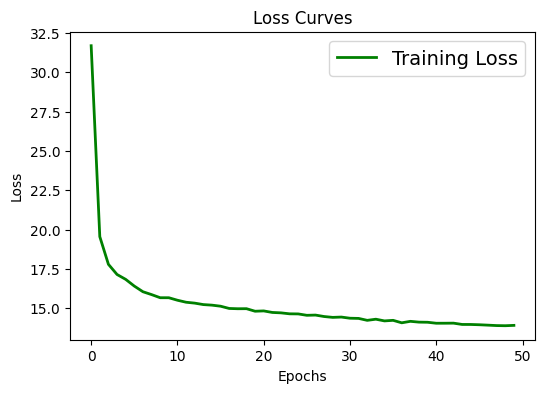

In [142]:
plt.figure(figsize=[6, 4])
plt.plot(train_loss_history, "green", linewidth=2.0)
plt.legend(["Training Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)
plt.show()

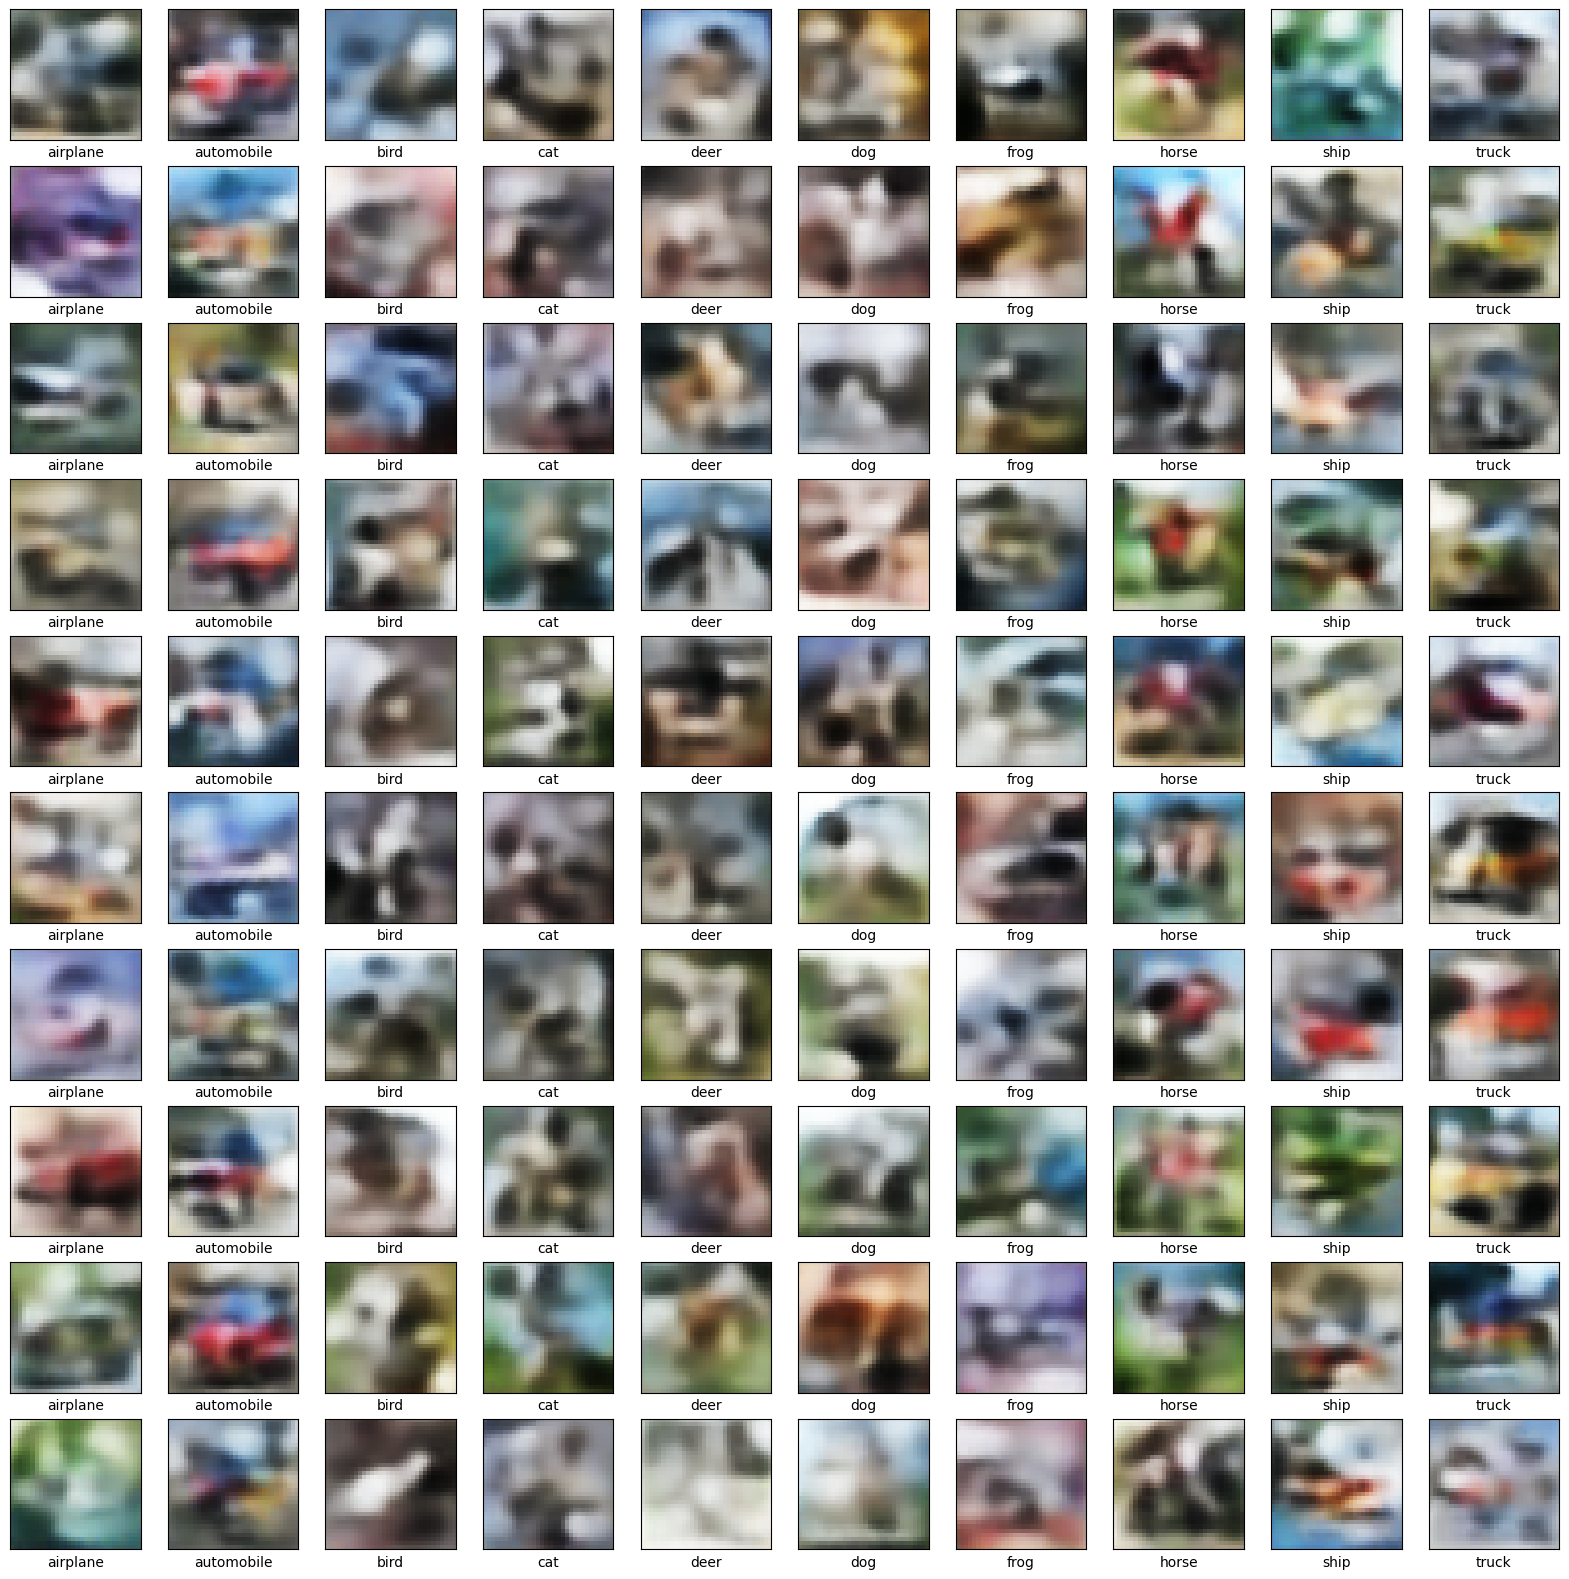

In [143]:
repeat_size = 1000
gen_images, gen_labels = model.generate_images(repeat_size)

save_image(
    gen_images[:10],
    "./outputs/cifar-10-cvae-outputs/temp/gen/evaluation.png",
)

pil_img = []

for img in gen_images:
    pil_img.append(transforms.ToPILImage()(img))

show_cifar10_images(pil_img, gen_labels)

## FID evaluation

Ref.

Inception v3 architecture

![Inception v3 architecture](./images/inception_v3.png)

[GAN in Pytorch with FID](https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid#References)

In [144]:
if evaluation:
    from torcheval.metrics.image import FrechetInceptionDistance

    def interpolate(images):
        """
        Inception v3 model 需要輸入為 299 * 299 * 3
        所以需要先將 32 * 32 * 3 的 cifar-10 資料重新調整大小
        """
        stack = []

        for img in images:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            stack.append(transforms.ToTensor()(resized_img))

        return torch.stack(stack)

    fid_metric = FrechetInceptionDistance().to("cpu")

    def fid_evaluation(real, gen):

        gen = interpolate(gen)
        real = interpolate(real)

        fid_metric.update(real, is_real=True)
        fid_metric.update(gen, is_real=False)
        fid = fid_metric.compute()

        return fid

    fids = []

    for batch_idx, (data, labels) in enumerate(test_loader):

        fid = fid_evaluation(data, gen_images[batch_idx * 1000 : (batch_idx * 1000) + 1000])
        fids.append(fid)

        print(
            "FID Evaluation: [{}/{} ({:.0f}%)]\tFID: {:.6f}".format(
                (batch_idx + 1) * len(data), len(test_loader.dataset), 100.0 * (batch_idx + 1) / len(test_loader), fid
            ),
            end="\r",
        )

    fid_metric.reset()

## Save model state dict

In [145]:
if save_model:
    torch.save(model.state_dict(), f"./models/state_dict/cifar-10-cvae-training-{version}.pth")

### Load model and using decoder

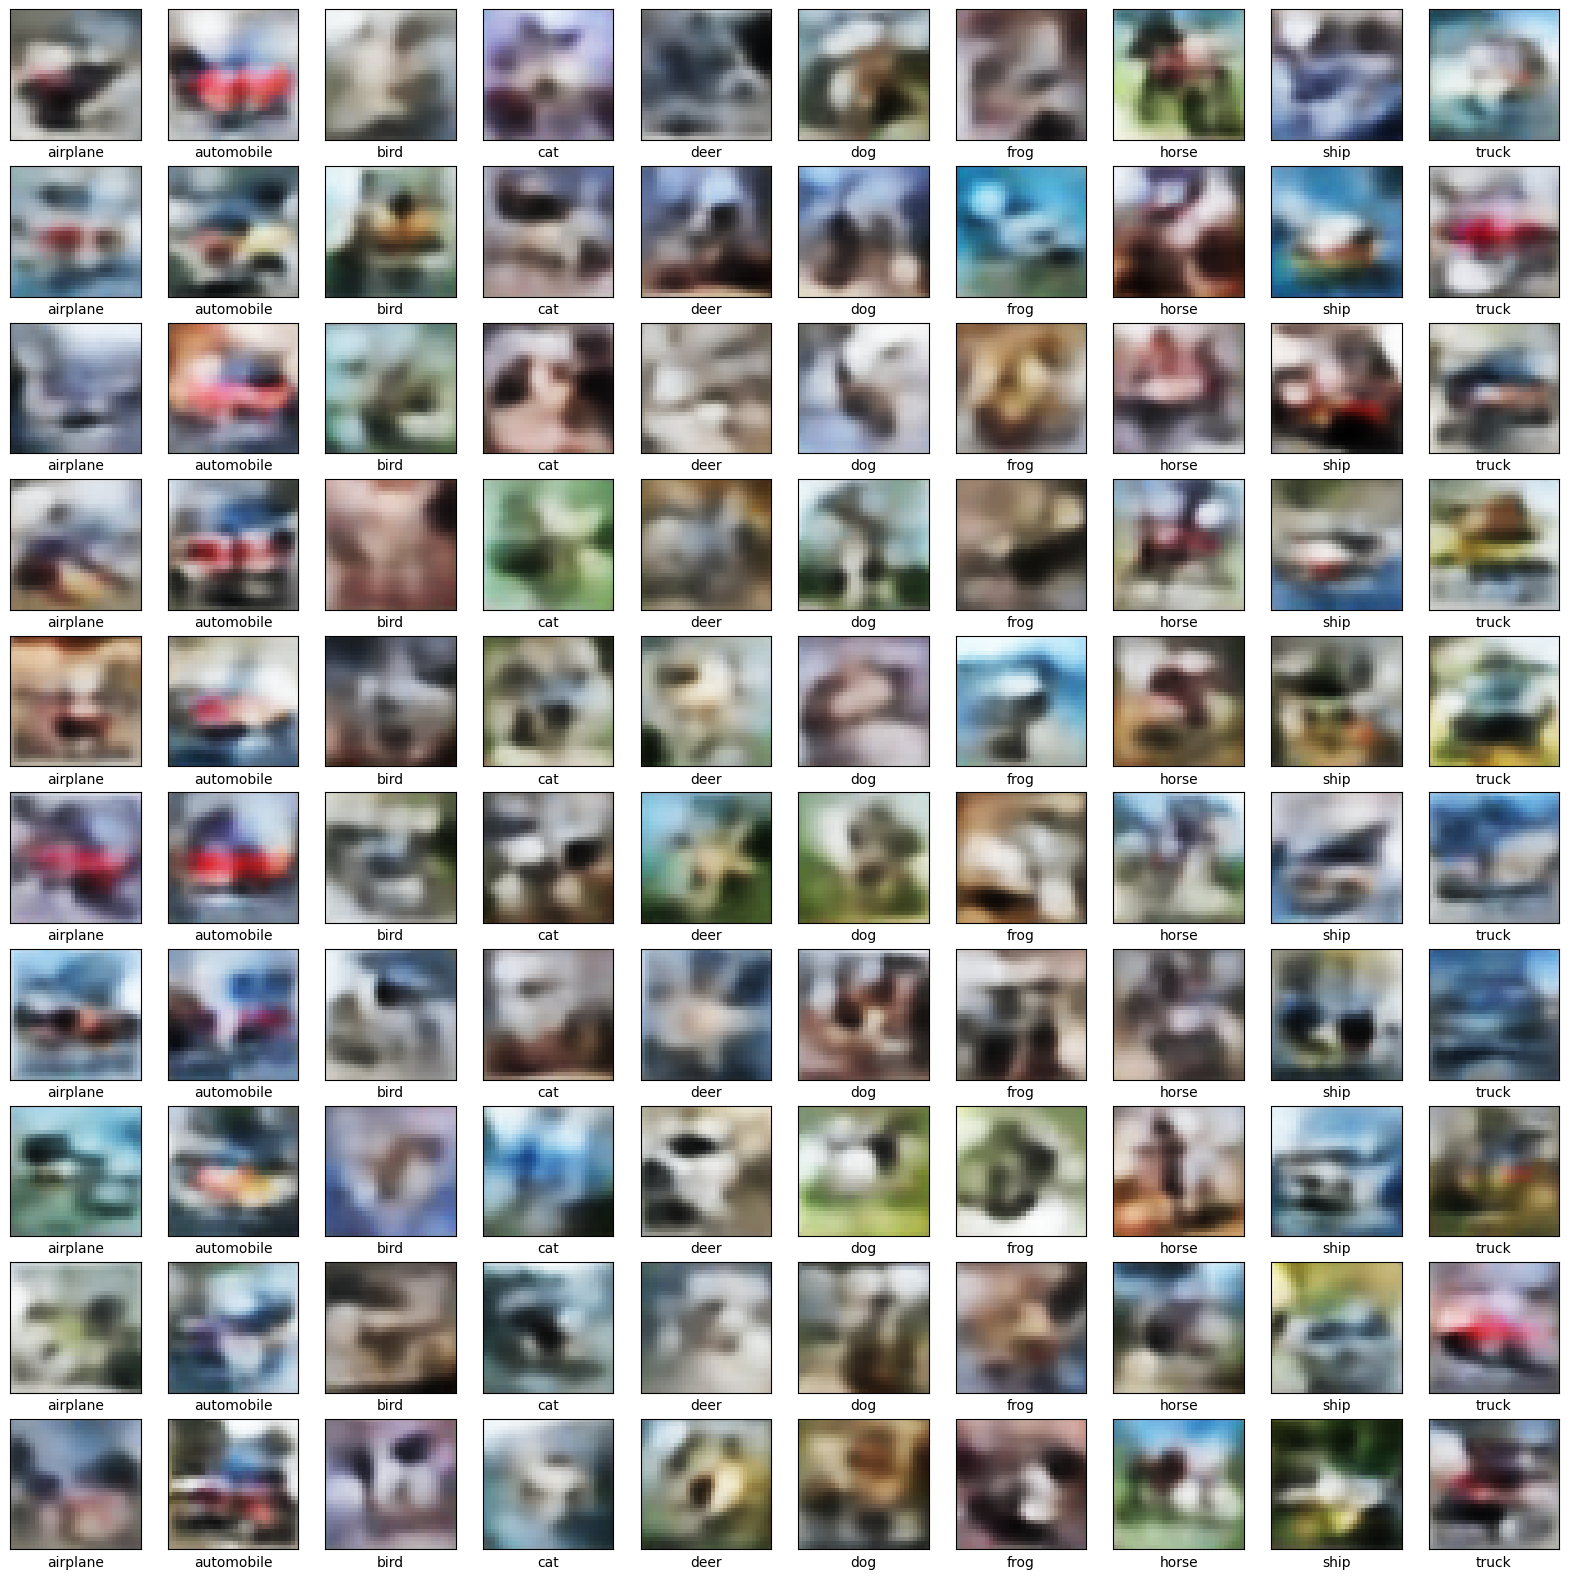

In [150]:
# training 3
# model = CVAE(
#     embedding_dim=10,
#     latent_dim=50,
#     model_sigma=False,
#     device=device,
#     conv_dims=[32, 64, 128],
#     deconv_dims=[128, 64, 32],
#     conv_kernel_size=4,
#     deconv_kernel_size=4,
# ).to(device)

# training 4
# model = CVAE(
#     embedding_dim=5,
#     latent_dim=50,
#     model_sigma=False,
#     device=device,
#     conv_dims=[64, 128, 256],
#     deconv_dims=[256, 128, 64],
#     conv_kernel_size=4,
#     deconv_kernel_size=4,
# ).to(device)

# training 5
model = CVAE(
    embedding_dim=5,
    latent_dim=50,
    model_sigma=False,
    device=device,
    conv_dims=[32, 64, 128],
    deconv_dims=[128, 64, 32],
    conv_kernel_size=4,
    deconv_kernel_size=4,
).to(device)

state = torch.load(f"./models/state_dict/cifar-10-cvae-training-{version}.pth")

model.load_state_dict(state)

gen_images, gen_labels = model.generate_images(1000)

pil_img = []

for img in gen_images:
    pil_img.append(transforms.ToPILImage()(img))

show_cifar10_images(pil_img, gen_labels)